In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from scipy.spatial.transform import Rotation as R
from pylorentz import Momentum4
from sklearn import metrics
plt.style.use('seaborn-pastel')


In [2]:
#mod1=lambda t:np.random.normal(10,3,t)
def genarrs(iN):
    farr=np.random.uniform(0,1,iN)# f
    parr=np.random.exponential(400,iN)# p
    marr=np.random.uniform(0,100,iN)# m
    return marr,parr,farr

def genarrsSig(iN):
    farr=np.random.uniform(0,1,iN)# f
    parr=np.random.exponential(400,iN)# p
    marr=np.random.normal(80,8,iN)# m
    return marr,parr,farr

#mod1=lambda t:np.random.normal(10,3,t)
def genarrsM(iN):
    farr=np.random.uniform(0,1,iN)# f
    parr=np.random.exponential(400,iN)# p
    marr=np.random.uniform(0,250,iN)# m
    marr1=np.random.uniform(0,marr*0.5)# m
    marr2=np.random.uniform(0,marr*0.5)# m
    return marr,parr,farr,marr1,marr2

In [3]:
#Massless Vecs
def vecsTheta(iMVal,iPVal,iFVal):
    lP1ZVal = iPVal/(1.+iFVal)
    lP2ZVal = iPVal-lP1ZVal
    num=4.*np.power(lP1ZVal,2)*np.power(iMVal,2)*iFVal+np.power(iMVal,4)
    denom=4.*np.power(lP2ZVal,2)+8.*lP1ZVal*lP2ZVal+4*np.power(lP1ZVal,2)+4.*np.power(iMVal,2)
    return np.sqrt(num/denom)

#Massive Vecs
def vecsMTheta(iMVal,iM1Val,iM2Val,iPVal,iFVal):
    lP1ZVal = iPVal/(1.+iFVal)
    lP2ZVal = iPVal-lP1ZVal
    num=4.*np.power(lP1ZVal,2)*np.power(iMVal,2)*iFVal+np.power(iMVal,4)
    num=num-4.*np.power(iM1Val,2)*np.power(lP2ZVal,2)-4.*np.power(iM2Val,2)*np.power(lP1ZVal,2)
    num=num-4.*np.power(lP1ZVal,2)*(iM1Val**2+iM2Val**2)*iFVal
    num=num-2*np.power(iMVal,2)*(iM1Val**2+iM2Val**2)+(iM1Val**2-iM2Val**2)**2
    num=np.maximum(num,0)
    denom=4.*np.power(lP2ZVal,2)+8.*lP1ZVal*lP2ZVal+4*np.power(lP1ZVal,2)+4.*np.power(iMVal,2)
    return np.sqrt(num/denom)

def vecs(iMVal,iPVal,iFVal):
    lPTheta1 = vecsTheta(iMVal,iPVal,iFVal)
    lPT1Val  = iPVal/(1.+iFVal)
    lPT2Val  = iPVal-lPT1Val
    theta1    = np.pi/2.-np.arctan(lPTheta1/lPT1Val)
    theta2    = np.pi/2.-np.arctan(lPTheta1/lPT2Val)
    eta1 = -1.*np.log(np.tan(theta1/2.))
    eta2 =     np.log(np.tan(theta2/2.))
    lVec1 = Momentum4.m_eta_phi_pt(0.,eta1,0.,lPT1Val)
    lVec2 = Momentum4.m_eta_phi_pt(0.,eta2,0.,lPT2Val)
    return lVec1,lVec2

def vecsRotate(iMVal,iPVal,iFVal,iPhiVal,iVec):
    #Get vectors in base frame about 0,0
    lVec1,lVec2 = vecs(iMVal,iPVal,iFVal)
    #now rotate them so that iVec is the center
    #print("A:",iVec.theta-np.pi/2,lVec1.theta,lVec2.theta)
    rphi = R.from_rotvec(-1.* iPhiVal * np.array([1, 0, 0]))#note z and x are swapped
    r    = R.from_rotvec(-1.*(iVec.theta-np.pi/2) * np.array([0, 1, 0]))
    lV1R = [lVec1.p_x/lVec1.p,lVec1.p_y/lVec1.p,lVec1.p_z/lVec1.p]
    lV2R = [lVec2.p_x/lVec2.p,lVec2.p_y/lVec2.p,lVec2.p_z/lVec2.p]
    lV1R = rphi.apply(lV1R)
    lV2R = rphi.apply(lV2R)
    lV1R = r.apply(lV1R)
    lV2R = r.apply(lV2R)
    t1 = lV1R[2]/(lV1R[0])#np.sqrt(lV1R[0]**2+lV1R[1]**2))
    t2 = lV2R[2]/(lV2R[0])#np.sqrt(lV2R[0]**2+lV2R[1]**2))
    theta1  = np.pi/2-np.arctan(t1)
    theta2  = np.pi/2-np.arctan(t2)
    phi1    = np.arctan2(lV1R[1],lV1R[0])
    phi2    = np.arctan2(lV2R[1],lV2R[0])
    #print(phi1,phi2)
    eta1 = -1.*np.log(np.tan((theta1)/2.))
    eta2 = -1.*np.log(np.tan((theta2)/2.))
    #print("phi:",phi1,phi2,iPhiVal,eta1,eta2) 
    lVec1 = Momentum4.e_eta_phi_p(lVec1.e,eta1,phi1,lVec1.p)
    lVec2 = Momentum4.e_eta_phi_p(lVec2.e,eta2,phi2,lVec2.p)
    #print("A:",iVec.theta-np.pi/2,lVec1.theta,lVec2.theta,lVec1.eta,lVec2.eta)
    return lVec1,lVec2

def vecsM(iMVal,iM1Val,iM2Val,iPVal,iFVal):
    lPTheta1 = vecsMTheta(iMVal,iM1Val,iM2Val,iPVal,iFVal)
    lPT1Val  = iPVal/(1.+iFVal)
    lPT2Val  = iPVal-lPT1Val
    theta1    = np.pi/2.-np.arctan(lPTheta1/lPT1Val)
    theta2    = np.pi/2.-np.arctan(lPTheta1/lPT2Val)
    eta1 = -1.*np.log(np.tan(theta1/2.))
    eta2 =     np.log(np.tan(theta2/2.))
    lVec1 = Momentum4.m_eta_phi_pt(iM1Val,eta1,0.,lPT1Val)
    lVec2 = Momentum4.m_eta_phi_pt(iM2Val,eta2,0.,lPT2Val)
    return lVec1,lVec2
#now a quick check
lV1,lV2 = vecs(15,100.,1.0)
print((lV1+lV2).p_t,(lV1+lV2).m)
lV1,lV2 = vecsM(15,5,1,100.,1.0)
print(lV1.m,lV2.m,(lV1+lV2).p_t,(lV1+lV2).m)
print(lV1.p_x,lV1.p_y,lV1.p_z,lV1.p,lV1.theta-np.pi/2)

100.0 15.0
5.000000000000048 1.0000000000002025 100.0 15.0
50.0 0.0 6.577543852349778 50.43078507350034 -0.13079980336385266


In [4]:
def vecs4(iMVal,iM1Val,iM2Val,iPVal,iFVal):
    #First Splitting
    lV1,lV2 = vecsM(iMVal,iM1Val,iM2Val,iPVal,iFVal)
    #Sampling fs
    farr   = np.random.uniform(0,1,2)
    phiarr = np.random.uniform(0,2.*np.pi,2)
    lV11,lV12 = vecsRotate(iM1Val,lV1.p,farr[0],phiarr[0],lV1)
    lV21,lV22 = vecsRotate(iM2Val,lV2.p,farr[1],phiarr[1],lV2)
    return lV11,lV12,lV21,lV22
#now quick check
lV1,lV2,lV3,lV4 = vecs4(100,25,15,1000.,0.1)
print((lV1+lV2+lV3+lV4).m,(lV1+lV2+lV3+lV4).p_t)

100.22176352749003 999.9777981951559


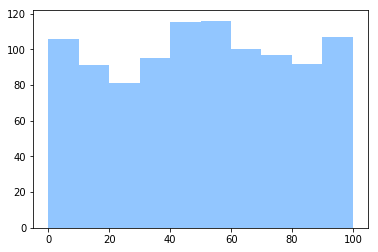

(array([560., 261., 115.,  37.,  13.,   9.,   2.,   2.,   0.,   1.]),
 array([5.69410579e-01, 3.48888210e+02, 6.97207010e+02, 1.04552581e+03,
        1.39384461e+03, 1.74216341e+03, 2.09048221e+03, 2.43880101e+03,
        2.78711981e+03, 3.13543861e+03, 3.48375741e+03]),
 <a list of 10 Patch objects>)

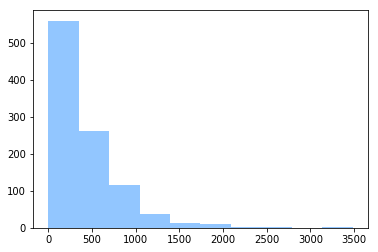

In [5]:
test=genarrs(1000)
testvecs=vecs(test[0],test[1],test[2])
mass=(testvecs[0]+testvecs[1]).m
plt.hist(mass)
plt.show()
pt=(testvecs[0]+testvecs[1]).p_t
plt.hist(pt)

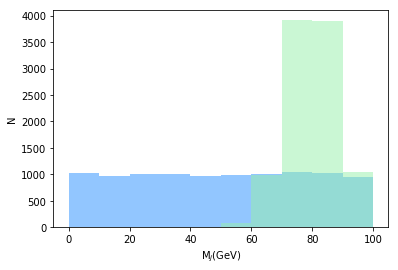

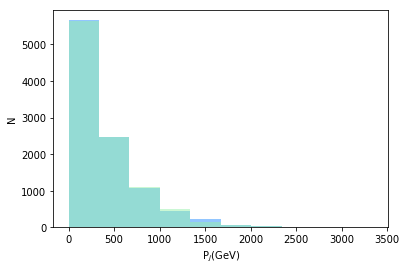

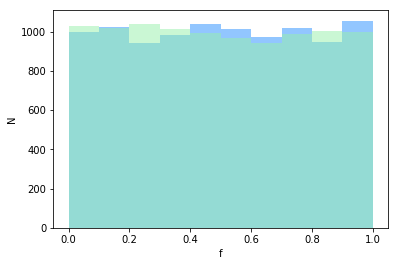

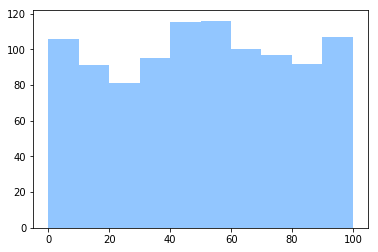

(array([560., 261., 115.,  37.,  13.,   9.,   2.,   2.,   0.,   1.]),
 array([5.69410579e-01, 3.48888210e+02, 6.97207010e+02, 1.04552581e+03,
        1.39384461e+03, 1.74216341e+03, 2.09048221e+03, 2.43880101e+03,
        2.78711981e+03, 3.13543861e+03, 3.48375741e+03]),
 <a list of 10 Patch objects>)

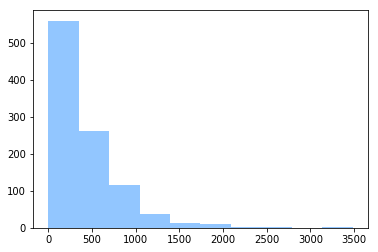

In [6]:
testsig=genarrsSig(10000)
testbkg=genarrs(10000)
_,bins,_=plt.hist(testbkg[0])
plt.hist(testsig[0],alpha=0.5,bins=bins)
plt.xlabel("M$_{j}$(GeV)")
plt.ylabel("N")
plt.show()

_,bins,_=plt.hist(testbkg[1])
plt.hist(testsig[1],alpha=0.5,bins=bins)
plt.xlabel("P$_{j}$(GeV)")
plt.ylabel("N")
plt.show()

_,bins,_=plt.hist(testbkg[2])
plt.hist(testsig[2],alpha=0.5,bins=bins)
plt.xlabel("f")
plt.ylabel("N")
plt.show()


testvecssig=vecs(testsig[0],testsig[1],testsig[2])
testvecsbkg=vecs(testbkg[0],testbkg[1],testbkg[2])
mass=(testvecs[0]+testvecs[1]).m
plt.hist(mass)
plt.show()
pt=(testvecs[0]+testvecs[1]).p_t
plt.hist(pt)

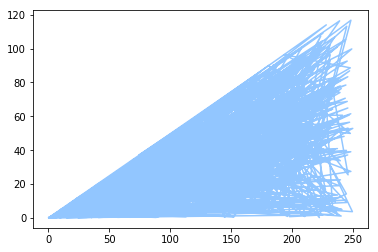

In [7]:
test=genarrsM(1000)
plt.plot(test[0],test[3])
#plt.hist(test[4])
plt.show()


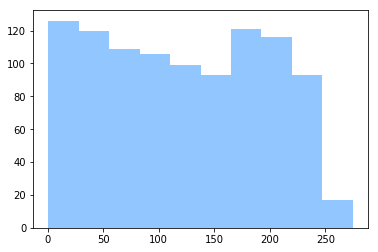

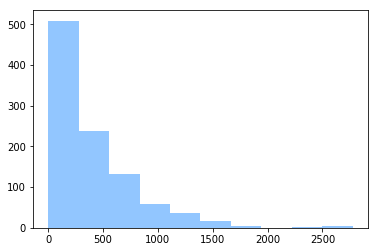

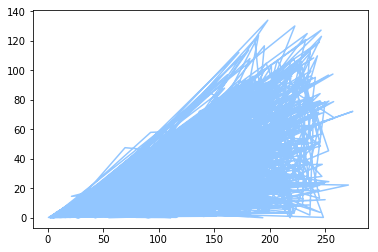

In [8]:
test=genarrsM(1000)
mass=np.array([])
pt=np.array([])
m1=np.array([])
for val in range(len(test[0])):
    lV1,lV2,lV3,lV4=vecs4(test[0][val],test[3][val],test[4][val],test[1][val],test[2][val])
    testvec=lV1+lV2+lV3+lV4
    m1=np.append(m1,(lV1+lV2).m)
    mass=np.append(mass,testvec.m)
    pt=np.append(pt,testvec.p_t)
    if testvec.m > 350:
        print("check!",testvec.p_t,test[1][val],testvec.m,test[0][val])
plt.hist(mass[mass < 1000])
plt.show()
plt.hist(pt)
plt.show()
plt.plot(mass,m1)
#plt.hist(test[4])
plt.show()


Now the challenge is to build an autoencoder that reproduces the input.

In [9]:
r = R.from_rotvec(0.3 * np.array([0, 1, 0]))
test=[1,0,0]
test=r.apply(test)
theta1  = np.arctan(test[2]/test[0])
print(theta1)

-0.3


/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Net(
  (hidden): Linear(in_features=3, out_features=10, bias=True)
  (act): ReLU()
  (predict): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
)
ytmptorch tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)
Finished Training
(4000,)
(4000,) [0. 0. 0. ... 1. 1. 1.] (4000,)


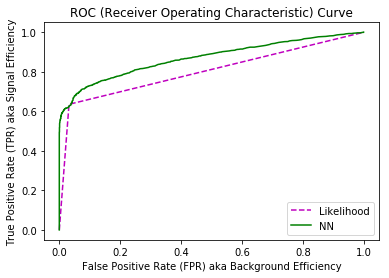

In [11]:
#now lets do a quick training 
bkg=genarrs(10000)
sig=genarrsSig(10000)
bkg=np.swapaxes(np.vstack((bkg[0],bkg[1],bkg[2])),0,1)
sig=np.swapaxes(np.vstack((sig[0],sig[1],sig[2])),0,1)

#do the usual prep
from sklearn.model_selection import train_test_split
sig_train, sig_test, bkg_train, bkg_test = train_test_split(sig, bkg, test_size = 0.20, random_state = 5)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
sig_train = scaler.fit_transform(sig_train)
sig_test  = scaler.transform    (sig_test)
bkg_train = scaler.transform    (bkg_train)
bkg_test  = scaler.transform    (bkg_test)

#lets train a likelihood
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
likelihood = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
x_tmp = np.concatenate((sig_train, bkg_train))
y_tmp = np.hstack((np.zeros(len(sig_train)), np.ones(len(bkg_train))))
x_test_tmp = np.concatenate((sig_test, bkg_test))
y_test_tmp = np.hstack((np.zeros(len(sig_test)), np.ones(len(bkg_test))))

likelihood.fit(x_tmp, y_tmp)
likelihood_test = likelihood.predict(x_test_tmp)

#lets train an NN with these 3 inputs
import torch
import torch.nn.functional as F
from torch.autograd import Variable

# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden  = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.act     = torch.nn.ReLU()
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.output  = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)      # activation function for hidden layer
        x = self.act(x)
        x = self.predict(x)             # linear output
        x = self.output(x)
        return x

net = Net(n_feature=sig_train.shape[1], n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003) 
x_tmp_torch = Variable(torch.from_numpy(x_tmp))
y_tmp_torch = Variable(torch.from_numpy(y_tmp))
print("ytmptorch",y_tmp_torch)
for epoch in range(500):
    # zero the parameter gradients
    outputs = net(x_tmp_torch.float())
    #print(outputs[:,0])
    loss = criterion(outputs.reshape(16000), y_tmp_torch.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(loss.item())

print('Finished Training')
torch.save(net.state_dict(), 'model.pt')
x_tmp_test_torch = Variable(torch.from_numpy(x_test_tmp))
nn_test = (net(x_tmp_test_torch.float())).data.numpy()[:,0]
print(nn_test.shape)
#Lets plot the ROC of the two
def compute_ROC(labels, predicts, npts=1001):
    cutvals = np.linspace(0.,1.,num=npts)
    print(labels.shape,labels,predicts.shape)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c in cutvals:
        fpr.append(float(len(predicts[(labels==0) & (predicts>c)]))/tot0)
        tpr.append(float(len(predicts[(labels==1) & (predicts>c)]))/tot1)    
    return np.array(fpr),np.array(tpr)

#likelihood_rocpts = compute_ROC(y_test_tmp,likelihood_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test_tmp, likelihood_test,True)
likelihood_rocpts=np.vstack((fpr,tpr))
nn_rocpts         = compute_ROC(y_test_tmp,nn_test)

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],        nn_rocpts[1],'g-',label="NN")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()



Net(
  (hidden): Linear(in_features=6, out_features=10, bias=True)
  (act): ReLU()
  (predict): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
)
Finished Training
(4000,) [0. 0. 0. ... 1. 1. 1.] (4000,)


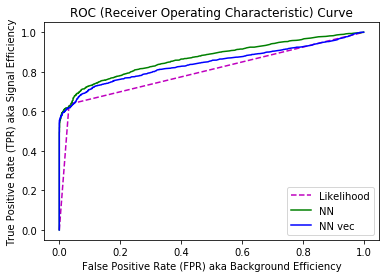

In [12]:
#now lets train an NN with 2 particle inputs
bkg=np.swapaxes(bkg,0,1)
sig=np.swapaxes(sig,0,1)
bkgvecs=vecs(bkg[0],bkg[1],bkg[2])
sigvecs=vecs(sig[0],sig[1],sig[2])
bkgvecs=np.swapaxes(np.vstack((bkgvecs[0].p_x,bkgvecs[0].p_y,bkgvecs[0].p_z,bkgvecs[1].p_x,bkgvecs[1].p_y,bkgvecs[1].p_z)),0,1)
sigvecs=np.swapaxes(np.vstack((sigvecs[0].p_x,sigvecs[0].p_y,sigvecs[0].p_z,sigvecs[1].p_x,sigvecs[1].p_y,sigvecs[1].p_z)),0,1)
sig_train, sig_test, bkg_train, bkg_test = train_test_split(sigvecs, bkgvecs, test_size = 0.20, random_state = 5, shuffle = True)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
sig_train = scaler.fit_transform(sig_train)
sig_test  = scaler.transform    (sig_test)
bkg_train = scaler.transform    (bkg_train)
bkg_test  = scaler.transform    (bkg_test)

x_tmp = np.concatenate((sig_train, bkg_train))
y_tmp = np.hstack((np.zeros(len(sig_train)), np.ones(len(bkg_train))))
x_test_tmp = np.concatenate((sig_test, bkg_test))
y_test_tmp = np.hstack((np.zeros(len(sig_test)), np.ones(len(bkg_test))))

#x_rand = np.random.permutation(len(x_tmp))
#x_tmp = x_tmp[x_rand]
#y_tmp = y_tmp[x_rand]

#x_test_rand = np.random.permutation(len(x_test_tmp))
#x_test_tmp = x_tmp[x_test_rand]
#y_test_tmp = y_tmp[x_test_rand]

net = Net(n_feature=sig_train.shape[1], n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003) 
x_tmp_torch = Variable(torch.from_numpy(x_tmp))
y_tmp_torch = Variable(torch.from_numpy(y_tmp))
for epoch in range(500):
    # zero the parameter gradients
    outputs = net(x_tmp_torch.float())
    loss = criterion(outputs[:,0], y_tmp_torch.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(loss.item())

print('Finished Training')
torch.save(net.state_dict(), 'model.pt')
x_tmp_test_torch = Variable(torch.from_numpy(x_test_tmp))
nn_test_vec = (net(x_tmp_test_torch.float())).data.numpy()[:,0]
nn_vec_rocpts         = compute_ROC(y_test_tmp,nn_test_vec)

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],        nn_rocpts[1],'g-',label="NN")
plt.plot(nn_vec_rocpts[0],        nn_rocpts[1],'b-',label="NN vec")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

#now lets train a transformer



In [13]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self,ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        print("d_model",d_model,"nhead",nhead,"dhid",d_hid,"nlayers",nlayers)
        #self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model  = d_model  
        self.decoder1 = nn.Linear(d_model*2, 10)
        self.decoder2 = nn.Linear(10, ntoken)
        self.output   = torch.nn.Sigmoid()

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        output = self.transformer_encoder(src, src_mask)
        output = output.permute(1,0,2)
        output = self.decoder1(output.flatten(1,2))
        output = self.decoder2(output)
        output = self.output(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


d_model 3 nhead 1 dhid 3 nlayers 2
(4000,) [0. 0. 0. ... 1. 1. 1.] (4000,)


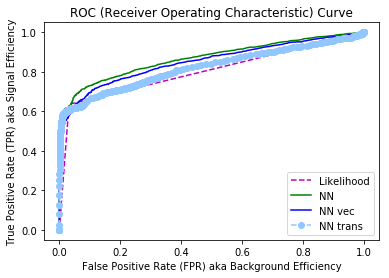

In [14]:
bptt=2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
src_mask = generate_square_subsequent_mask(bptt).to(device)
x_tmp_torch_out = x_tmp_torch.reshape(len(x_tmp_torch),2,3)
x_tmp_torch_out = x_tmp_torch_out.permute(1,0,2)

x_test_tmp_torch_out = x_tmp_test_torch.reshape(len(x_tmp_test_torch),2,3).to(device)
x_test_tmp_torch_out = x_test_tmp_torch_out.permute(1,0,2).to(device)


ntoken  = 1
emsize  = 3  # embedding dimension
d_hid   = 3  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead   = 1  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntoken,emsize,nhead, d_hid, nlayers, dropout).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003) 
model.train()  # turn on train mode
x_tmp_trans_test=x_tmp_torch_out[:,:].float().to(device)
y_tmp_torch = y_tmp_torch.float().to(device)
#print(x_tmp_trans_test.shape)
#print(x_tmp_trans_test.permute(1,0,2).flatten(1,2).shape)
for epoch in range(500):
    # zero the parameter gradients
    outputs = model(x_tmp_trans_test,src_mask)
    #print(outputs.shape,y_tmp_torch.shape)
    loss = criterion(outputs[:,0], y_tmp_torch)
    optimizer.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    #print(loss.item())

#output = model(data, src_mask)
#loss = criterion(output.view(-1, ntokens), targets)
#optimizer.zero_grad()
#loss.backward()
#torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
#optimizer.step()

model.eval()
nn_test_trans_vec = (model(x_test_tmp_torch_out.float(),src_mask)).cpu().data.numpy()[:,0]
nn_trans_vec_rocpts         = compute_ROC(y_test_tmp,nn_test_trans_vec)

#rand_tensor = torch.rand((bptt,2,3))
#print(rand_tensor.shape)
#output = model(rand_tensor,src_mask)
#output = model(test,src_mask)
#output = model(test,src_mask)
#print("output",output.shape,output)

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],          nn_rocpts[1],'g-',label="NN")
plt.plot(nn_vec_rocpts[0],      nn_vec_rocpts[1],'b-',label="NN vec")
plt.plot(nn_trans_vec_rocpts[0],nn_trans_vec_rocpts[1],'o--',label="NN trans")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

In [15]:
nn_test_trans_vec.shape

(4000,)

In [16]:
x_tmp_test_torch
nn_test_vec

array([0.26961958, 0.5879252 , 0.3788923 , ..., 0.96803343, 0.9980782 ,
       0.9305098 ], dtype=float32)

In [17]:
nn_test_vec>0.9

array([False, False, False, ...,  True,  True,  True])

In [18]:
x_NN = x_tmp_test_torch.numpy()[nn_test_vec>0.9]

In [19]:
x_NN.shape

(939, 6)

In [20]:
x_NN[0]

array([ 0.19147497,  0.        , -3.86880351, -0.82636531,  0.        ,
        3.86880351])

In [21]:
nn_test_trans_vec>0.9

array([False, False, False, ...,  True,  True,  True])

In [22]:
xfirstpart = x_test_tmp_torch_out.float().cpu().data.numpy()[0]

In [23]:
xfirstpart[nn_test_trans_vec>0.95].shape

(919, 3)

In [24]:
selected = xfirstpart[nn_test_trans_vec>0.95]

In [25]:
selected

array([[ 0.35778373,  0.        , -3.8119342 ],
       [ 0.19147497,  0.        , -3.8688035 ],
       [-0.8576511 ,  0.        , -0.8080227 ],
       ...,
       [-0.41369918,  0.        , -2.6891382 ],
       [-0.0789874 ,  0.        , -3.6407623 ],
       [ 0.5000547 ,  0.        , -4.033237  ]], dtype=float32)

In [26]:
from mpl_toolkits.mplot3d import axes3d

In [27]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [28]:
rng = np.random.default_rng()

In [29]:
points = rng.random((30, 2)) 

In [30]:
points.shape

(30, 2)

In [31]:
hull1 = ConvexHull(np.column_stack((selected[:,0],selected[:,2])))

In [32]:
hull2 = ConvexHull(np.column_stack((x_NN[:,0],x_NN[:,2])))

In [33]:
np.column_stack((selected[:,0],selected[:,2])).shape

(919, 2)

In [34]:
hull1.vertices

array([561, 643, 722, 277, 412, 288, 337,  49, 180, 655,  34, 786, 902,
       340, 882], dtype=int32)

In [41]:
lastline = [hull2.vertices[-1],hull2.vertices[0]]

In [42]:
lastline

[210, 175]

In [40]:
hull2.vertices[0]

175

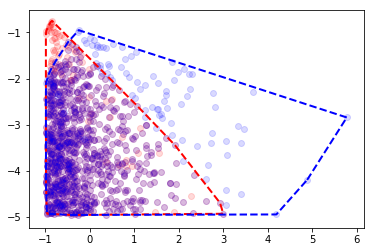

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(selected[:,0],selected[:,2], c='r', marker='o',alpha=0.15)
ax.scatter(x_NN[:,0],x_NN[:,2], c='b', marker='o',alpha=0.15)
ax.plot(selected[hull1.vertices,0], selected[hull1.vertices,2], 'r--', lw=2)
ax.plot(x_NN[hull2.vertices,0], x_NN[hull2.vertices,2], 'b--', lw=2)
ax.plot(x_NN[lastline,0], x_NN[lastline,2], 'b--', lw=2)

fig.show()

In [46]:
ax.scatter(selected[:,0],selected[:,1], c='r', marker='o')

In [52]:
%matplotlib inline

In [51]:
plt.show()

(1, 4, 10000) (1, 4, 10000)
(1, 4, 10000) (2, 4, 10000)
(1, 4, 10000) (1, 4, 10000)
(1, 4, 10000) (2, 4, 10000)


/Users/pharris/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass pos_label=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(20000,) (20000,)
(20000,) (20000,)


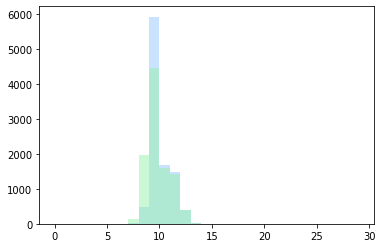

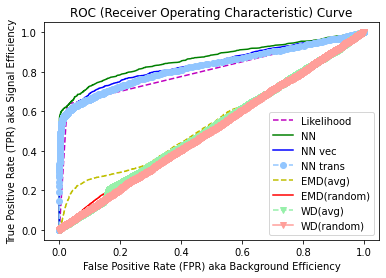

In [25]:
import energyflow as ef
#Now lets compute the EMD 
#bkg=np.swapaxes(bkg,0,1)
#sig=np.swapaxes(sig,0,1)
bkgvecs=vecs(bkg[0],bkg[1],bkg[2])
sigvecs=vecs(sig[0],sig[1],sig[2])

#ev0=np.array([[1,0,0,1],[1,0,1,0]])
#ev1=np.array([[1,0,1,0],[10,0,1,1]])
#emd=ef.emd.emd(ev0, ev1, R=1, return_flow=True)
def prep(iVecs):
    testvec=np.array([])
    for pVal in range(len(iVecs)):
        fourvec=np.vstack((iVecs[pVal].e,iVecs[pVal].p_t,iVecs[pVal].eta,iVecs[pVal].phi))
        fourvec=fourvec.reshape(1,4,fourvec.shape[1])
        if pVal == 0: 
            testvec=fourvec
        else:
            testvec=np.vstack((testvec,fourvec))
        print(fourvec.shape,testvec.shape)
    testvec=np.swapaxes(np.swapaxes(testvec,0,2),1,2)
    return testvec

bkgvecs=prep(bkgvecs)
sigvecs=prep(sigvecs)
#bkgvecs=bkgvecs.reshape(10000,8)
#sigvecs=sigvecs.reshape(10000,8)
#scaler    = StandardScaler(copy=True, with_mean=False, with_std=True)
#sigvecs   = scaler.fit_transform(sigvecs)
#bkgvecs   = scaler.transform    (bkgvecs)
#sigvecs=sigvecs.reshape(10000,2,4)
#bkgvecs=bkgvecs.reshape(10000,2,4)


#print(bkgvecs[:,0].mean(),bkgvecs[:,1].mean(),bkgvecs[:,2].mean(),bkgvecs[:,3].mean())
bkgavg=np.array([])
for pVal0 in range(sigvecs.shape[1]):
    fourvec=np.array([])
    for pVal1 in range(sigvecs.shape[2]):
        fourvec=np.append(fourvec,bkgvecs[:,pVal0,pVal1].mean())
    if pVal0 == 0:
        bkgavg=fourvec
    else:
        bkgavg = np.vstack((bkgavg,fourvec))

bkgrdmid=np.random.permutation(len(bkgvecs))
bkgrdm=bkgvecs[bkgrdmid]

emds=np.array([])
emdsr=np.array([])
wds=np.array([])
wdsr=np.array([])
pVal=0
for pVec in sigvecs:
    emd=ef.emd.emd(pVec,bkgavg, R=1, return_flow=True)
    emdr=ef.emd.emd(pVec,bkgrdm[pVal], R=1, return_flow=True)
    wd = wasserstein_distance(u_values=pVec.flatten(),v_values=bkgavg.flatten())
    wdr= wasserstein_distance(u_values=pVec.flatten(),v_values=bkgrdm[pVal].flatten())
    emds  = np.append(emds,emd[0])
    emdsr = np.append(emdsr,emdr[0])
    wds  = np.append(wds,wd)
    wdsr = np.append(wdsr,wdr)
    pVal=pVal+1

emdb=np.array([])
emdbr=np.array([])
wdb=np.array([])
wdbr=np.array([])

pVal=0
for pVec in bkgvecs:
    emd=ef.emd.emd(pVec,bkgavg, R=1, return_flow=True)
    emdr=ef.emd.emd(pVec,bkgrdm[pVal], R=1, return_flow=True)
    wd = wasserstein_distance(u_values=pVec.flatten(),v_values=bkgavg.flatten())
    wdr= wasserstein_distance(u_values=pVec.flatten(),v_values=bkgrdm[pVal].flatten())
    emdb = np.append(emdb,emd[0])
    emdbr = np.append(emdbr,emdr[0])
    wdb  = np.append(wdb,wd)
    wdbr = np.append(wdbr,wdr)
    pVal=pVal+1
    
x_emd   = np.concatenate((emds,emdb))
x_emdr  = np.concatenate((emdsr,emdbr))

x_wd    = np.concatenate((wds,wdb))
x_wdr  =  np.concatenate((wdsr,wdbr))

y_emd   = np.hstack((np.zeros(len(emds)), np.ones(len(emdb))))

fpr, tpr, thresholds = metrics.roc_curve(y_emd, -1.*x_emd,True)
emd_rocpts=np.vstack((fpr,tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_emd, -1.*x_emdr,True)
emd_rocpts2=np.vstack((fpr,tpr))

print(x_wd.shape,y_emd.shape)
fpr, tpr, thresholds = metrics.roc_curve(y_emd, x_wd,True)
wd_rocpts=np.vstack((fpr,tpr))

print(x_wdr.shape,y_emd.shape)
fpr, tpr, thresholds = metrics.roc_curve(y_emd, x_wdr,True)
wd_rocpts2=np.vstack((fpr,tpr))


plt.hist(np.log(emds),bins=range(0,30,1),alpha=0.5)
plt.hist(np.log(emdb),bins=range(0,30,1),alpha=0.5)
plt.show()

#emd_rocpts2         = compute_ROC(y_emd,1-0.1*np.log(x_emd))

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],          nn_rocpts[1],'g-',label="NN")
plt.plot(nn_vec_rocpts[0],      nn_vec_rocpts[1],'b-',label="NN vec")
plt.plot(nn_trans_vec_rocpts[0],nn_trans_vec_rocpts[1],'o--',label="NN trans")
plt.plot(emd_rocpts[0],emd_rocpts[1],'y--',label="EMD(avg)")
plt.plot(emd_rocpts2[0],emd_rocpts2[1],'r-',label="EMD(random)")
plt.plot(wd_rocpts[0],wd_rocpts[1],'v--',label="WD(avg)")
plt.plot(wd_rocpts2[0],wd_rocpts2[1],'v-',label="WD(random)")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

[ 1.04254383e-14 -4.03010958e-15  1.78701498e-15]


/Users/pharris/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass pos_label=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


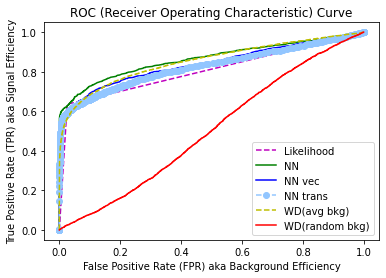

In [28]:
#Now run 1D wasserstein
#sig=np.swapaxes(sig,0,1)
#bkg=np.swapaxes(bkg,0,1)
sig_train, sig_test, bkg_train, bkg_test = train_test_split(sig, bkg, test_size = 0.20, random_state = 5)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
sig_train = scaler.fit_transform(sig_train)
sig_test  = scaler.transform    (sig_test)
bkg_train = scaler.transform    (bkg_train)
bkg_test  = scaler.transform    (bkg_test)

bkgavg=np.array([])
for pVal0 in range(sig_train.shape[1]):
    bkgavg = np.append(bkgavg,sig_train[:,pVal0].mean())
print(bkgavg)
    
bkgrdmid=np.random.permutation(len(sig_train))
bkgrdm=bkg_train[bkgrdmid]

emds=np.array([])
emdsr=np.array([])
pVal=0
for pVec in sig_train:
    wd = wasserstein_distance(u_values=pVec,v_values=bkgavg)
    wdr= wasserstein_distance(u_values=pVec,v_values=bkgrdm[pVal])
    emds  = np.append(emds, wd)
    emdsr = np.append(emdsr,wdr)
    pVal=pVal+1
    
emdb=np.array([])
emdbr=np.array([])
pVal=0
for pVec in bkg_train:
    wd = wasserstein_distance(u_values=pVec,v_values=bkgavg)
    wdr= wasserstein_distance(u_values=pVec,v_values=bkgrdm[pVal])
    emdb = np.append(emdb,wd)
    emdbr = np.append(emdbr,wdr)
    pVal=pVal+1
    
x_emd   = np.concatenate((emds,emdb))
x_emdr  = np.concatenate((emdsr,emdbr))
y_emd   = np.hstack((np.zeros(len(emds)), np.ones(len(emdb))))

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_emd, x_emd,True)
emd_rocpts=np.vstack((fpr,tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_emd, x_emdr,True)
emd_rocpts2=np.vstack((fpr,tpr))

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],          nn_rocpts[1],'g-',label="NN")
plt.plot(nn_vec_rocpts[0],      nn_vec_rocpts[1],'b-',label="NN vec")
plt.plot(nn_trans_vec_rocpts[0],nn_trans_vec_rocpts[1],'o--',label="NN trans")
plt.plot(emd_rocpts[0],emd_rocpts[1],'y--',label="WD(avg bkg)")
plt.plot(emd_rocpts2[0],emd_rocpts2[1],'r-',label="WD(random bkg)")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

0.12059173732995987
0.33519598841667175
(4000,) [0. 0. 0. ... 1. 1. 1.] (4000,)
(4000,) [0. 0. 0. ... 1. 1. 1.] (4000,)
(4000,) [0. 0. 0. ... 1. 1. 1.] (4000,)


/Users/pharris/Library/Python/3.7/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


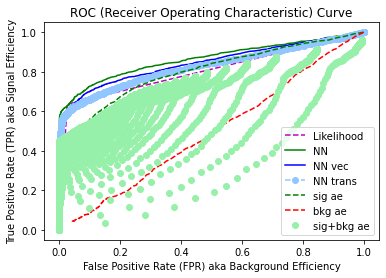

In [60]:
#finally lets train an AE to do this, starting from particles
# this is one way to define a network
class AE(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_ae):
        super(AE, self).__init__()
        self.hidden1  = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.act1     = torch.nn.ReLU()
        self.latent   = torch.nn.Linear(n_hidden, n_ae)   # hidden layer
        self.act2     = torch.nn.ReLU()
        self.hidden2  = torch.nn.Linear(n_ae, n_hidden)   # hidden layer
        self.act3     = torch.nn.ReLU()
        self.predict  = torch.nn.Linear(n_hidden, n_feature)   # output layer
        
    def forward(self, x):
        x = self.hidden1(x)      # activation function for hidden layer
        x = self.act1(x)
        x = self.latent(x)          
        x = self.act2(x)            
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.predict(x)
        return x
    
    #def latent(self,x):
    #    x = self.hidden1(x)
    #    x = self.act1(x)
    #    x = self.latent(x)          
    #    return x

        
nae=1
sig_ae = AE(n_feature=sig_train.shape[1], n_hidden=10, n_ae=nae)     # define the network
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sig_ae.parameters(), lr=0.003) 
sig_train_torch = Variable(torch.from_numpy(sig_train))
for epoch in range(1000):
    # zero the parameter gradients
    outputs = sig_ae(sig_train_torch.float())
    loss    = criterion(outputs, sig_train_torch.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(loss.item())
print(loss.item())

bkg_ae = AE(n_feature=bkg_train.shape[1], n_hidden=10, n_ae=nae)     # define the network
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bkg_ae.parameters(), lr=0.003) 
bkg_train_torch = Variable(torch.from_numpy(bkg_train))
for epoch in range(1000):
    # zero the parameter gradients
    outputs = bkg_ae(bkg_train_torch.float())
    loss    = criterion(outputs, bkg_train_torch.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(loss.item())

criterion = torch.nn.MSELoss(reduce=False)
x_test_torch   = Variable(torch.from_numpy(x_test_tmp))
outputs        = sig_ae(x_test_torch.float())
loss_test      = criterion(outputs,x_test_torch.float())
loss_test1      = torch.sum(loss_test,axis=1).detach().numpy()
loss_sig_vec_rocpts         = compute_ROC(y_test_tmp,0.1*loss_test1)

outputs        = bkg_ae(x_test_torch.float())
loss_test      = criterion(outputs,x_test_torch.float())
loss_test2     = torch.sum(loss_test,axis=1).detach().numpy()
loss_bkg_vec_rocpts         = compute_ROC(y_test_tmp,0.1*loss_test2)

#Lets plot the ROC of the two
def compute_ROC2D(labels, predicts1, predicts2, npts=201):
    cutvals = np.linspace(0.,1.,num=npts)
    print(labels.shape,labels,predicts1.shape)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c1 in cutvals:
        for c2 in cutvals:
            fpr.append(float(len(predicts1[(labels==0) & (predicts1>c1) & (predicts1<c2)]))/tot0)
            tpr.append(float(len(predicts1[(labels==1) & (predicts1>c1) & (predicts2<c2)]))/tot1)    
    return np.array(fpr),np.array(tpr)

loss_vec_rocpts             = compute_ROC2D(y_test_tmp,0.1*loss_test1,0.1*loss_test2)

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],          nn_rocpts[1],'g-',label="NN")
plt.plot(nn_vec_rocpts[0],      nn_vec_rocpts[1],'b-',label="NN vec")
plt.plot(nn_trans_vec_rocpts[0],nn_trans_vec_rocpts[1],'o--',label="NN trans")
plt.plot(loss_sig_vec_rocpts[0],    loss_sig_vec_rocpts[1],'g--',label="sig ae")
plt.plot(loss_bkg_vec_rocpts[0],    loss_bkg_vec_rocpts[1],'r--',label="bkg ae")
plt.plot(loss_vec_rocpts[0],        loss_vec_rocpts[1]    ,'o',label="sig+bkg ae")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

/Users/pharris/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass pos_label=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


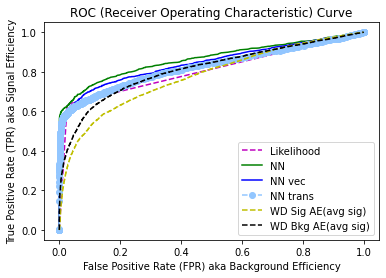

In [65]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
sig_ae.latent.register_forward_hook(get_activation('act2'))
bkg_ae.latent.register_forward_hook(get_activation('act2'))

sig_train_torch = Variable(torch.from_numpy(sig_train))
bkg_train_torch = Variable(torch.from_numpy(bkg_train))

sig_latentb = bkg_ae(sig_train_torch.float())
sig_latentb = activation['act2']
bkg_latentb = bkg_ae(bkg_train_torch.float())
bkg_latentb = activation['act2']

sig_latents = sig_ae(sig_train_torch.float())
sig_latents = activation['act2']
bkg_latents = sig_ae(bkg_train_torch.float())
bkg_latents = activation['act2']


scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
sig_latents = scaler.fit_transform(sig_latents)
bkg_latents = scaler.transform    (bkg_latents)
sig_latentb = scaler.fit_transform(sig_latentb)
bkg_latentb = scaler.transform    (bkg_latentb)

bkgavgs=np.array([])
bkgavgb=np.array([])
for pVal0 in range(sig_latents.shape[1]):
    bkgavgs = np.append(bkgavgs,sig_latents[:,pVal0].mean())
    bkgavgb = np.append(bkgavgb,sig_latentb[:,pVal0].mean())
    
emdss=np.array([])
emdsb=np.array([])
for pVec in sig_latents:
    wd = wasserstein_distance(u_values=pVec,v_values=bkgavgs)
    emdss  = np.append(emdss, wd)

for pVec in sig_latentb:
    wd = wasserstein_distance(u_values=pVec,v_values=bkgavgb)
    emdsb  = np.append(emdsb, wd)
        
emdbs=np.array([])
emdbb=np.array([])

for pVec in bkg_latents:
    wd = wasserstein_distance(u_values=pVec,v_values=bkgavgs)
    emdbs = np.append(emdbs,wd)

for pVec in bkg_latentb:
    wd = wasserstein_distance(u_values=pVec,v_values=bkgavgb)
    emdbb = np.append(emdbb,wd)

    
x_emds   = np.concatenate((emdss,emdbs))
x_emdb   = np.concatenate((emdsb,emdbb))
y_emd   = np.hstack((np.zeros(len(emds)), np.ones(len(emdb))))

fpr, tpr, thresholds = metrics.roc_curve(y_emd, x_emds,True)
emd_rocptss=np.vstack((fpr,tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_emd, x_emdb,True)
emd_rocptsb=np.vstack((fpr,tpr))

plt.plot(likelihood_rocpts[0],likelihood_rocpts[1],'m--',label="Likelihood")
plt.plot(nn_rocpts[0],          nn_rocpts[1],'g-',label="NN")
plt.plot(nn_vec_rocpts[0],      nn_vec_rocpts[1],'b-',label="NN vec")
plt.plot(nn_trans_vec_rocpts[0],nn_trans_vec_rocpts[1],'o--',label="NN trans")
plt.plot(emd_rocptss[0],emd_rocptss[1],'y--',label="WD Sig AE(avg sig)")
plt.plot(emd_rocptsb[0],emd_rocptsb[1],'k--',label="WD Bkg AE(avg sig)")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()


In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))


#finally lets train an AE to do this, starting from particles
# this is one way to define a network
class VAE(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_ae):
        super(AE, self).__init__()
        self.n_ae     = n_ae
        self.hidden1  = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.act1     = torch.nn.ReLU()
        self.latent   = torch.nn.Linear(n_hidden, 2*n_ae)   # hidden layer
        self.act2     = torch.nn.ReLU()
        self.hidden2  = torch.nn.Linear(n_ae, n_hidden)   # hidden layer
        self.act3     = torch.nn.ReLU()
        self.predict  = torch.nn.Linear(n_hidden, n_feature)   # output layer
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    def forward(self, x):
        x = self.hidden1(x)      # activation function for hidden layer
        x = self.act1(x)
        x = self.latent(x).view(-1,2,self.n_ae)          
        x = self.act2(x)  
        mu      = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        x = self.reparametrize(mu,log_var)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.predict(x)
        return x
  
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
  
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def train(self, batch, batch_idx):
        x, _ = batch
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        kl = self.kl_divergence(z, mu, std)
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })
        return elbo
